<a href="https://colab.research.google.com/github/hiwasaki1712/ml_edu_notes/blob/main/LGBM_optuna_penguins_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM のハイパーパラメータ調整のサンプル

分類モデルの学習設定を最適化する流れを紹介する。  
* palmerpenguins データを読み込み、訓練データとテストデータに分割
* optuna を使い、訓練データでハイパーパラメータを調整
* 最適な設定で学習
* テストデータで評価

___
使用モデル・データ
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/)  
決定木ベースのアルゴリズムで推論する、2016年に発表された機械学習手法。


* [palmerpenguinsデータ](https://github.com/allisonhorst/palmerpenguins/tree/main)  
南極パーマーランドの3種のペンギンのデータ  
irisデータに変わる分析用データを目指して、くちばしの幅と長さ、フリッパー長、体重、性別などの計測データが収集・整理されている  

![penguins](https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/lter_penguins.png?raw=true)

参考  
* [Optuna の拡張機能 LightGBM Tuner によるハイパーパラメータ自動最適化](https://tech.preferred.jp/ja/blog/hyperparameter-tuning-with-optuna-integration-lightgbm-tuner/)
* [Optunaで始めるハイパーパラメータ最適化 (PFN)](https://tech.preferred.jp/ja/blog/an-introduction-to-hyperparameter-optimization-with-optuna-ieice/)


In [1]:
%%capture
!pip install optuna
!pip install optuna-integration[lightgbm]

In [4]:
import os, sys
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, RocCurveDisplay, roc_auc_score)
import optuna
import optuna.integration.lightgbm as op_lgb
from optuna.integration import LightGBMTuner, LightGBMTunerCV
import lightgbm as lgb
import pickle

print (np.__version__)
print (pd.__version__)
print (matplotlib.__version__)
print (sklearn.__version__)
print (optuna.__version__)

1.26.4
2.2.2
3.8.0
1.5.2
4.1.0


In [3]:
### 実験の再現性のため、乱数シードを定義
random_state = 137

## データセットの準備

* palmerpenguins データを読み込み、可視化してデータを観察。  
* Holdout 法で train-test 分割する。  
※ クラス数を維持するように分割する(stratify)

In [5]:
### データをダウンロード
!git clone https://github.com/allisonhorst/palmerpenguins.git

Cloning into 'palmerpenguins'...
remote: Enumerating objects: 1985, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 1985 (delta 168), reused 357 (delta 136), pack-reused 1577 (from 1)
Receiving objects: 100% (1985/1985), 44.34 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (1095/1095), done.


使用するデータセットについて設定

※ 別のデータを使う場合は、ファイルパスを書き換え、そのデータに合うように正解ラベル列と使用しない列（あれば）の名称を適切に変更してください。
データのCSVファイルの1行目に、各列の名称が記載されている前提です。


In [6]:
### データセットのファイルパスを定義
data_path = '/content/palmerpenguins/inst/extdata/penguins.csv'

### 正解ラベルの列名を定義
target_col_name = "species"

### 使用しない列名を定義
drop_cols_name = ['island', 'sex', 'year']


### ファイルが存在するか確認
if os.path.exists(data_path):
    print ('Data file exists. OK, move on!')
else:
    print ('Oops, Data file not found...')

Data file exists. OK, move on!


In [7]:
### データの読み込み
df_penguins = pd.read_csv(data_path)

# 目的変数の名称を辞書化
# target_names_dict = {ii: val for ii, val in enumerate(df_penguins[target_col_name].unique())}

df_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


ここでは、くちばしの長さと幅、フリッパーの長さ、体重のみ説明変数として使うことにします

In [8]:
### 使わない列を削除
df_penguins.drop(columns=drop_cols_name, inplace=True)
df_penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0


データが欠損している行を削除します。
欠損値が含まれると、分類モデルに入力したときエラーになります。

In [9]:
### 欠損値のある行を削除
print ('original shape', df_penguins.shape)

df_penguins.dropna(inplace=True)
print ('w/o NaN', df_penguins.shape)

df_penguins.info()

original shape (344, 5)
w/o NaN (342, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   bill_length_mm     342 non-null    float64
 2   bill_depth_mm      342 non-null    float64
 3   flipper_length_mm  342 non-null    float64
 4   body_mass_g        342 non-null    float64
dtypes: float64(4), object(1)
memory usage: 16.0+ KB


In [10]:
### ユニークな目的変数の名称を取得
target_names = df_penguins[target_col_name].unique()
### クラス数
n_class = len(target_names)

### 各クラスの色を定義
color_dict = {target_names[ii] : cm.jet(ii/n_class) for ii in range(n_class)}
color = df_penguins[target_col_name].map(color_dict)

まずはデータセットを観察しよう

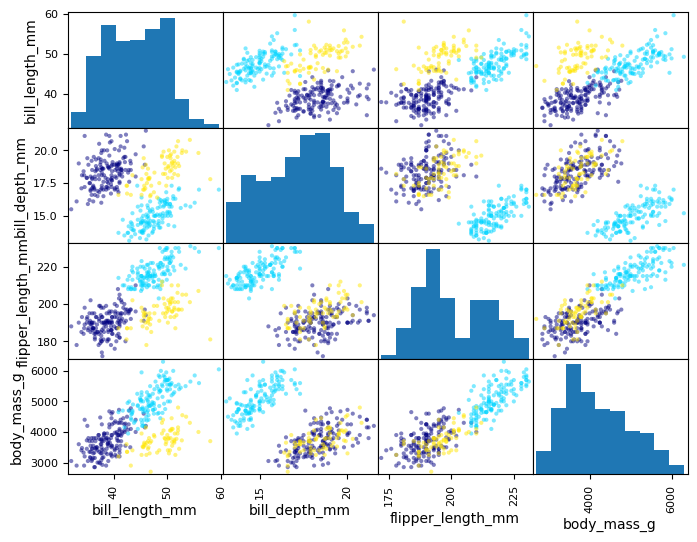

In [11]:
### データセットのペアプロットを表示
scatter_matrix(df_penguins.drop(columns=[target_col_name]),
               color=color,
               figsize=(8,6))
plt.show()

上図では、青色がアデリー、水色がジェンツー、黄色がヒゲ

散布図を眺めると：
* ジェンツーペンギンが比較的大型で、アデリーとヒゲペンギンは同じようなサイズ感
* くちばしは、アデリーが短めで、ジェンツーが細め
![bill](https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/culmen_depth.png?raw=true)

In [12]:
### 各クラスのサンプル数を確認
df_penguins[target_col_name].value_counts()

,count
species,
Adelie,151
Gentoo,123
Chinstrap,68


Holdout 法で train-valid-test 分割する。  
ここでは、まず test 用に3割抽出する。残りの7割を学習用として、それをさらにtrain : valid = 7 : 3 になるよう分割する。  
※ クラス数を維持するように分割する(stratify)

In [13]:
### データセットを train-val-test 分割

X = df_penguins.drop(columns=[target_col_name])
y = df_penguins[target_col_name]

### 正解ラベルを数値に変換
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
### クラス番号と正解ラベル名の対応
class_names = label_encoder.classes_
print (class_names)

### 学習用データとテストデータに分割
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                     test_size=0.3,
                                     stratify=y,
                                     random_state=random_state)

### 学習用セットを、さらに訓練セット(train)と評価セット(valid)に分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val,
                                  test_size=0.3,
                                  stratify=y_train_val,
                                  random_state=random_state)

['Adelie' 'Chinstrap' 'Gentoo']


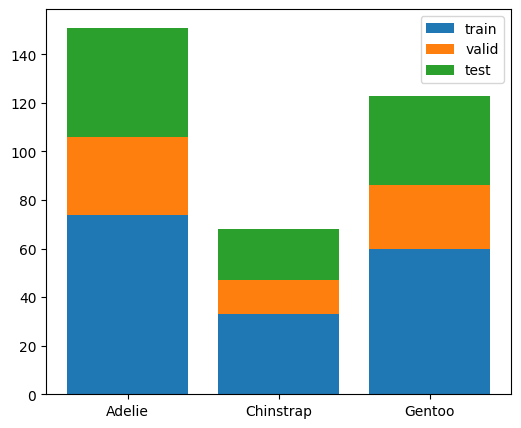

In [21]:
### 分割したデータの各クラスの割合を確認
plt.figure(figsize=(6, 5))
bottom_counts = np.zeros(n_class)
for ky, data in zip(['train', 'valid', 'test'], [y_train, y_valid, y_test]):
    labels, counts = np.unique(data, return_counts=True)
    labels = label_encoder.inverse_transform(labels)
    plt.bar(labels, counts, label=ky, bottom=bottom_counts)
    bottom_counts += counts
plt.legend()
plt.show()

## ハイパーパラメータ・チューニング

ハイパーパラメータ（i.e. 人が決めなければいけないパラメータ）を最適化する

* データ準備で切出した Train データで訓練し、Validation データのスコアを最適化する

調整するハイパーパラメータの種類や、それぞれの値の探索範囲、最適化の順序などは経験則の世界。
Optuna では、lightGBMのハイパーパラメータを効率的に最適化するツールが用意されている。


注意  
最適なモデルを探す過程では、Train データと Validation データのみ使います。  
この過程では Test データを使ってはいけません。Test データで性能評価をした後で、この過程に戻ってもいけません。  
Test データとは未知のデータに対する汎化性能を測定するためのものだからです。モデルをサービスインしてから新たに取得されるデータを模擬したもの、と考えましょう。

In [ ]:
%%capture
from lightgbm import early_stopping, log_evaluation

dtra = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_valid, label=y_valid)

### 評価関数などの設定
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': n_class,
    "verbosity": -1,
    'verbose_eval': False,
}

best_params, tuning_history = dict(), list()
booster = op_lgb.train(params,
                       dtra,
                       valid_sets=dval,
                       callbacks=[early_stopping(50),
                                  log_evaluation(0)],
                       optuna_seed=random_state,
                      )
best_params = booster.params

In [23]:
### ベストスコア
booster.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('multi_logloss',
                           0.00031132562946854136)])})

In [24]:
### 最適なハイパーパラメータ
best_params

{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'verbosity': -1,
 'verbose_eval': False,
 'feature_pre_filter': False,
 'lambda_l1': 1.0008525697439436e-08,
 'lambda_l2': 2.0637525277095304e-05,
 'num_leaves': 31,
 'feature_fraction': 0.88,
 'bagging_fraction': 0.47288937707080797,
 'bagging_freq': 1,
 'min_child_samples': 20,
 'num_iterations': 1000}

## 最適化したハイパーパラメータで分類

最適なハイパーパラメータでモデルを学習する  
ハイパーパラメータ最適化での訓練データ (Train) と評価データ (Validation) を合わせたデータを使う

In [25]:
### Bestのハイパーパラメータの分類器を train-val set で学習
dtrain = lgb.Dataset(X_train_val, label=y_train_val)

clf = lgb.train(best_params, dtrain, valid_sets=dtrain,
                callbacks=[log_evaluation(0)],
                )

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [26]:
### 学習データに対するスコア
clf.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss',
                           0.0017488298703562989)])})

In [27]:
### 学習済みモデルを保存
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [28]:
### 学習済みモデルを読み込み
with open('model.pkl', 'rb') as f:
    clf = pickle.load(f)

## 学習結果の評価

Test データを使って学習済みモデルの汎化性能を評価する。

注意  
この結果が悪くても、ハイパーパラメータ最適化のパートに戻ってモデル選択をやり直してはいけない。  
Test データでの評価を繰り返して高性能のモデルを作ると、Test データに対する最適化をしている状態になり（データリーク）、汎化性能を測れない。

###一般的な性能評価

分類モデルの評価でよく使われる評価指標の計算や可視化を行う

#### 評価指標各種

まずは、訓練データとテストデータそれぞれに対して、正解率を求める

In [29]:
### train と test データの正解率をそれぞれ計算
for ky, data, y in zip(['train', 'test'], [X_train_val, X_test], [y_train_val, y_test]):
    pred = clf.predict(data)
    print (f'{ky} acc. = {accuracy_score(y, np.argmax(pred, axis=1))}')

train acc. = 1.0
test acc. = 0.970873786407767


次に、Test データの分類結果を取得し、いくつかの切り口で結果を評価する

In [30]:
# testセットに対する分類結果（各クラスの確率値）を取得
y_score = clf.predict(X_test)
# 確率値から分類ラベルに変換
y_pred = np.argmax(y_score, axis=1)

分類タスクの評価指標は正解率以外にもあり、見比べることで分類モデルの性能の特徴がわかる。


また、多クラスの場合、[各クラス平均の取り方](https://scikit-learn.org/1.5/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel)が複数ある。
クラス間にサンプル数の偏りがあると、平均の取り方でスコアが変わる。  
不均衡データで正解率だけ見るのはダメ！  
不均衡の影響を受けないのは macro 平均。

詳しくは[こちら](https://github.com/hiwasaki1712/ml_edu_notes/blob/main/evaluation_metrics.md#roc-reciever-operating-characteristic-%E6%9B%B2%E7%B7%9A)で解説しています。


In [31]:
### Test データに対する Metricsをサマリ
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.95      0.90      0.93        21
           2       1.00      1.00      1.00        37

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



#### 混同行列 (confusion matrix)



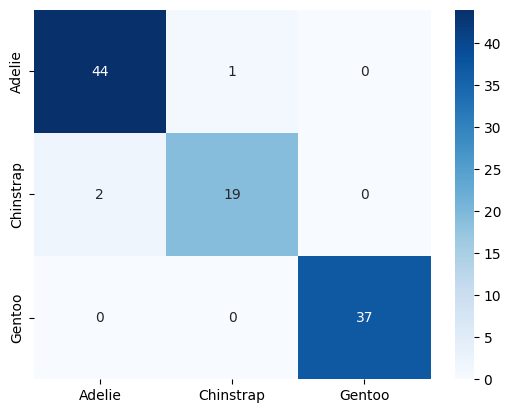

In [32]:
### Test データの混同行列をプロット
conf_matrix = confusion_matrix(y_test, y_pred,
                 sample_weight=None,
                 normalize=None)

sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues', fmt='d')

plt.show()

#### [ROC (reciever operating characteristic) 曲線](https://scikit-learn.org/1.5/modules/model_evaluation.html#roc-metrics)
分類モデルが予測した確率をラベルに変換するときの閾値を変化させたときの真陽性率 (TPR; true positive rate) と儀陽性率 (FPR; false positive rate) の関係を図示したもの。


詳しくは[こちら](https://github.com/hiwasaki1712/ml_edu_notes/blob/main/evaluation_metrics.md#roc-reciever-operating-characteristic-%E6%9B%B2%E7%B7%9A)

ROC曲線の理解のため、まず分類モデルが予測する確率値のヒストグラムを描く

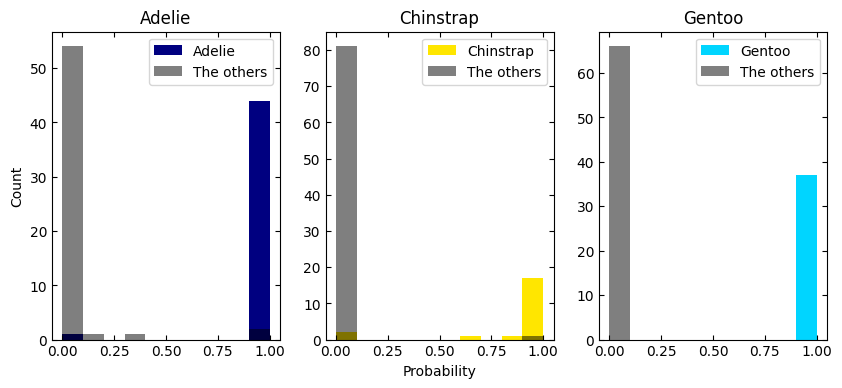

In [33]:
### テストデータでの各クラスの確率値ヒストグラム

fig = plt.figure(figsize=(10, 4))
axs = fig.subplots(1, n_class)

for ii, cls_name in enumerate(class_names):
    ax = axs[ii]

    ### 該当クラスの確率値のヒストグラムをプロット
    cls_id = ii
    ax.hist(y_score[y_test==cls_id, ii],
            bins=10,
            range=(0, 1),
            color=color_dict[cls_name],
            label=f'{cls_name}')

    ### 該当クラス以外の確率値のヒストグラムをプロット
    ax.hist(y_score[y_test!=cls_id, ii],
            bins=10,
            range=(0, 1),
            color='k',
            alpha=0.5,
            label=f'The others')

    ### グラフのタイトル
    ax.set_title(cls_name)
    ### 軸ラベル
    if ii == 0:
        ax.set_ylabel('Count')
    if ii == 1:
        ax.set_xlabel('Probability')
    ### 凡例
    ax.legend()
    ### 軸目盛の設定
    ax.tick_params(axis='both', which='major', direction='in', top='on', right='on')

plt.show()

確率値に閾値を決めて、その閾値以上のサンプルをそのクラスの予測値とする。通常の閾値は0.5。

閾値を1から0へ、つまりヒストグラムの右から左へ動かして、TPRとFPRの関係をプロットしたものがROC曲線。


0 Adelie
1 Chinstrap
2 Gentoo


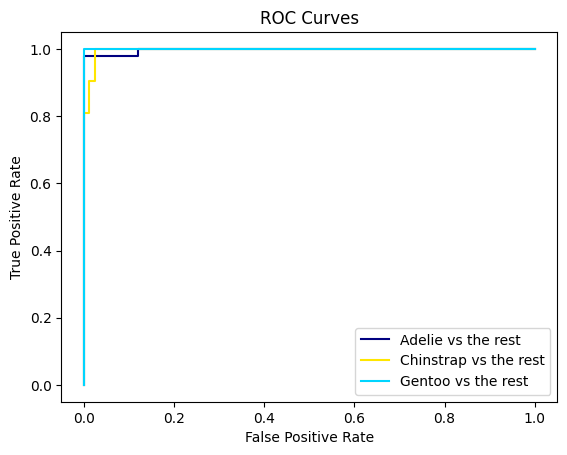

In [35]:
### Test データの ROC カーブをプロット

### 便宜上、正解ラベルをone-hot表現にする
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)


ax = plt.gca()

### クラスごとにROCをプロット
for ii, cls_name in enumerate(class_names):
    print (ii, cls_name)
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, ii], y_score[:, ii],)
    ax.plot(fpr, tpr,
            color=color_dict[cls_name],
            label=f"{cls_name} vs the rest")

ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
plt.show()

ROC曲線では、左上の点が理想的で、TPRが1、FPRが0の全て正しく答えられた状態。  
右下が最悪で、TPRが0、FPRが1で全て間違える状態。

曲線の下側の面積 (AUC; area under the curve) が1に近いほど理想に近づく。

ROC曲線とヒストグラムを見比べて、
* ヒゲペンギンは他と比べて、正解クラスで低確率に予測されやすい傾向（recall 低め）
* アデリーペンギンは他と比べて、不正解クラスで高確率に予測されやすい傾向（precision 低め）

詳しくは[こちら](https://github.com/hiwasaki1712/ml_edu_notes/blob/main/evaluation_metrics.md#roc-reciever-operating-characteristic-%E6%9B%B2%E7%B7%9A)

In [36]:
### Test データの ROC AUC を計算

print ('One-vs-One ROC AUC:')
print ('micro-avg:   ', roc_auc_score(y_onehot_test, y_score, multi_class='ovo', average='micro'))
print ('macro-avg:   ', roc_auc_score(y_onehot_test, y_score, multi_class='ovo', average='macro'))
print ('weighted-avg:', roc_auc_score(y_onehot_test, y_score, multi_class='ovo', average='weighted'))

print ('\nOne-vs-Rest ROC AUC')
print ('micro-avg:   ', roc_auc_score(y_onehot_test, y_score, multi_class='ovr', average='micro'))
print ('macro-avg:   ', roc_auc_score(y_onehot_test, y_score, multi_class='ovr', average='macro'))
print ('weighted-avg:', roc_auc_score(y_onehot_test, y_score, multi_class='ovr', average='weighted'))

One-vs-One ROC AUC:
micro-avg:    0.9981619379771892
macro-avg:    0.9979445623684479
weighted-avg: 0.998117860321556

One-vs-Rest ROC AUC
micro-avg:    0.9981619379771892
macro-avg:    0.9979445623684479
weighted-avg: 0.998117860321556


この例ではスコア高く、どの計算方法でもほぼ差がない

###モデル固有の評価・解釈

LightGBM は決定木ほどの解釈性は高くないが、特徴量重要度を求めることはできる

In [37]:
### 特徴量重要度を表示
feature_importance = clf.feature_importance()

for ii, feat_name in enumerate(X_test.columns):
    print (f'{feat_name:20s}: {feature_importance[ii]:>.3f}')

bill_length_mm      : 608.000
bill_depth_mm       : 752.000
flipper_length_mm   : 465.000
body_mass_g         : 381.000




---